**Detecção de Fraudes em Transações de Cartão de Crédito**

A detecção de fraudes em transações de cartão de crédito é um desafio crucial enfrentado pelas instituições financeiras na era digital. A sofisticação das técnicas de fraude demanda métodos avançados de Machine Learning e análise de dados para identificar padrões suspeitos em tempo real, garantindo a segurança dos consumidores e a integridade do sistema financeiro.

A natureza dinâmica das estratégias dos fraudadores requer sistemas de detecção igualmente ágeis e adaptáveis. Este desafio é ampliado pela presença de conjuntos de dados desbalanceados, nos quais as transações fraudulentas são uma pequena fração do total, demandando técnicas especializadas para minimizar falsos positivos e maximizar a precisão do modelo.

O desenvolvimento de modelos eficazes de Machine Learning para detecção de fraudes em transações de cartão de crédito é essencial para proteger os consumidores e as instituições financeiras. Este trabalho visa explorar estratégias avançadas de modelagem de dados e algoritmos de aprendizado de máquina, com o objetivo de criar um sistema robusto e eficiente de detecção de fraudes, garantindo a segurança e confiabilidade das transações financeiras.

### Dicionário de Dados

Trans_date_trans_time: Timestamp of the transaction (date and time).

Cc_num:Unique customer identification number.

MerchantThe merchant involved in the transaction.

Category Transaction type (e.g., personal, childcare).

Amt:Transaction amount.

First: Cardholder's first name.

Last Cardholder's last name.

Gender: Cardholder's gender.

Street: Cardholder's street address.

City: Cardholder's city of residence.

State: Cardholder's state of residence.

Zip: Cardholder's zip code.

Lat:Latitude of cardholder's location.

Long: Longitude of cardholder's location.

City_pop:Population of the cardholder's city.

Job:Cardholder's job title.

Dob: Cardholder's date of birth.

Trans_num: Unique transaction identifier.

Unix_time: Transaction timestamp (Unix format).

Merch_lat:Merchant's location (latitude).

Merch_long: Merchant's location (longitude).

Is_fraud:Fraudulent transaction indicator (1 = fraud, 0 = legitimate). This is the target variable for classification purposes.

# Class

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

class Fraud_Detection:
    def __init__(self):
        """
        Classe para modelagem de detecção de fraudes em transações de cartão de crédito.

        Atributos:
        - data_raw: DataFrame contendo os dados brutos das transações.
        - data_preprocessed: DataFrame contendo os dados após pré-processamento.
        - X: Conjunto de características (features) do modelo.
        - y: Rótulos das transações (0 para legítimas, 1 para fraudulentas).
        - y_predict: Rótulos previstos pelo modelo para as transações.
        - classes: Lista contendo as classes de transações ('Legítimas', 'Fraudulentas').
        
    """
        self.data_raw = None
        self.data_preprocessed = None
        self.X = None
        self.X_raw = None
        self.y = None
        self.y_predict = None
        self.scaler = None
        self.classes = ['Legítimas', 'Fraudulentas']
    
    def load_dataset(self, dataset_path:str) -> None:
        """
        Carrega o conjunto de dados de transações brutos a partir de um arquivo CSV.

        Parâmetros:
        - dataset_path: Caminho para o arquivo CSV contendo os dados brutos das transações.

        Retorna:
        Nenhum. Os dados brutos são carregados e armazenados no atributo `data_raw`.

        """
        self.data_raw = pd.read_csv(dataset_path, index_col = 0)
    
    def data_description(self):
        """
        Descreve as características do conjunto de dados de transações brutos.

        Esta função imprime uma mensagem que inclui o número de linhas e colunas do conjunto de dados,
        o número de variáveis de cada tipo presente no conjunto de dados, o total de valores nulos,
        e o balanço entre transações legítimas e fraudulentas.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. A descrição dos dados é impressa no console.
        """
        df1 = self.data_raw
        # Mensagem descrevendo os tipos de variáveis e suas quantidades
        mensagem = f'O dataset possui {df1.shape[0]} linhas e {df1.shape[1]} colunas.\n'
        mensagem += "O dataset possui as seguintes variáveis:\n"
        for tipo, quantidade in df1.dtypes.value_counts().items():
            mensagem += f"- {quantidade} variáveis do tipo '{tipo}'\n"
        mensagem += f'O dataset possui o total de {df1.isnull().sum().sum()} valores nulos.\n'
        mensagem += f"O dataset possui o seguinte balanceanento:\n- Transações Legítimas: {df1.is_fraud.value_counts()[0]}\n- Transações Fraudelentas: {df1.is_fraud.value_counts()[1]}"
        print(mensagem)
    
    def descriptive_statistics(self, num:list) -> pd.DataFrame:
        """
        Calcula estatísticas descritivas para as variáveis numéricas do conjunto de dados.

        Esta função calcula as estatísticas descritivas básicas, incluindo medidas de tendência central
        (média, mediana) e medidas de dispersão (desvio padrão, mínimo, máximo, amplitude, assimetria e curtose).

        Parâmetros:
        - num: Lista de variáveis numéricas para as quais as estatísticas descritivas serão calculadas.

        Retorna:
        Um DataFrame contendo as estatísticas descritivas para as variáveis numéricas do conjunto de dados.
        """

        # Central Tendency - mean, median
        ct1 = pd.DataFrame(num.apply(np.mean)).T
        ct2 = pd.DataFrame(num.apply(np.median)).T
        # Dispersion - std, min, max, range, skew, curtosis
        d1 = pd.DataFrame(num.apply(min)).T
        d2 = pd.DataFrame(num.apply(max)).T
        d3 = pd.DataFrame(num.apply(lambda x: x.max()-x.min())).T
        d4 = pd.DataFrame(num.apply(np.std)).T
        d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T
        ctd = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
        ctd.columns = ['features', 'mean','median','min','max','range','std','skew','kurtosis']
        return ctd

    def descriptive_statistics_amt(self) -> None:
        """
        Calcula estatísticas descritivas para o valor das transações, separadas por transações legítimas e fraudulentas,
        e plota histogramas para visualizar a distribuição do valor das transações.

        Esta função calcula estatísticas descritivas para o valor das transações, incluindo média e mediana,
        e plota histogramas separados para transações legítimas e fraudulentas.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. A descrição estatística e os histogramas são exibidos no console.
        """
        df1 = self.data_raw
        ds = pd.concat([self.descriptive_statistics(df1.loc[df1.is_fraud == 0][['amt']]),
                        self.descriptive_statistics(df1.loc[df1.is_fraud == 1][['amt']])])
        ds['transacao'] = ['Legítimas', 'Fraudulentas']
        display(ds)
        # Crie uma figura e eixos com 1 linha e 2 colunas
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plotar o primeiro histograma (Transações Legítimas)
        sns.histplot(data=df1.loc[df1.is_fraud == 0], x='amt', bins=20, color='blue', ax=axes[0])
        axes[0].axvline(x=df1.loc[df1.is_fraud == 0, 'amt'].mean(), color='black', linestyle='--', label=f'Média: {df1.loc[df1.is_fraud == 0, 'amt'].mean():.2f}')
        axes[0].set_title('Transações Legítimas')
        axes[0].set_xlabel('Valor')
        axes[0].set_ylabel('Frequência')
        axes[0].legend()
        # Plotar o segundo histograma (Transações Fraudulentas)
        sns.histplot(data=df1.loc[df1.is_fraud == 1], x='amt', bins=20, color='red', ax=axes[1])
        axes[1].axvline(x=df1.loc[df1.is_fraud == 1, 'amt'].mean(), color='black', linestyle='--', label=f'Média: {df1.loc[df1.is_fraud == 1, 'amt'].mean():.2f}')
        axes[1].set_title('Transações Fraudulentas')
        axes[1].set_xlabel('Valor')
        axes[1].set_ylabel('Frequência')
        axes[1].legend()
        # Ajustar layout
        plt.tight_layout()
        # Mostrar o gráfico
        plt.show()
    
    def change_data_type(self) -> None:
        """
        Converte o tipo de dados de algumas colunas do conjunto de dados para o tipo de dados apropriado.

        Esta função converte as colunas 'trans_date_trans_time', 'dob' e 'unix_time' para o tipo de dados de data e hora.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. O conjunto de dados pré-processado é armazenado no atributo `data_preprocessed`.
        """
        df2 = self.data_raw
        df2.trans_date_trans_time = pd.to_datetime(df2.trans_date_trans_time, dayfirst=True)
        df2.dob = pd.to_datetime(df2.dob, dayfirst=True)
        df2.unix_time = pd.to_datetime(df2.unix_time, unit = 's')
        self.data_preprocessed = df2

    def feature_engineering(self) -> None:

        """
        Realiza a engenharia de variáveis no conjunto de dados pré-processado.

        Esta função adiciona novas características ao conjunto de dados, incluindo a idade do cliente com base na data de nascimento,
        características de tempo (mês, dia, dia da semana, hora e minuto da transação) e a proporção de fraudes por habitante nas cidades.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. O conjunto de dados pré-processado, com as novas características adicionadas, é armazenado no atributo `data_preprocessed`.
        """
        
        df3 = self.data_preprocessed
        # Variável de Idade
        df3['age'] = df3['dob'].apply(lambda x: relativedelta(datetime.now(), x).years)
        print('     >> Age feature')
        # Variáveis de Tempo
        df3['month'] = df3.trans_date_trans_time.dt.month
        df3['day'] = df3.trans_date_trans_time.dt.day
        df3['weekday'] = df3.trans_date_trans_time.dt.weekday
        df3['hour'] = df3.trans_date_trans_time.dt.hour
        df3['minute'] = df3.trans_date_trans_time.dt.minute
        print('     >> Time features')

        # Criando um df com as Cidades e suas maiores Populações encontradas
        # No datafram originais, a mesma cidade aparece com populações diferetes 
        cidades = df3.groupby('city')['city_pop'].max().reset_index()
        city_fraud = df3.groupby('city')['is_fraud'].sum()
        cidades = pd.merge(cidades, city_fraud, on = 'city')
        cidades['fraud_per_pop'] = cidades.is_fraud / cidades.city_pop
        print('     >> Fraud per City Habitant feature')

        # JOIN DAS CIDADES COM A BASE DE TRANSAÇÕES
        df3['city_pop'] = df3.apply(lambda x: cidades.loc[cidades['city'] == x['city'], 'city_pop'].values[0] if x['city'] in cidades['city'].values else x['city_pop'], axis=1)

        # Join para pegar a proporção de frauders por habitante
        df3 = pd.merge(df3, cidades[['city', 'fraud_per_pop']], on = 'city')

        self.data_preprocessed = df3

    def feature_selection(self) -> None:
        """
        Realiza a seleção de características no conjunto de dados pré-processado.

        Esta função seleciona um subconjunto de características relevantes para o problema de detecção de fraudes,
        incluindo a categoria da transação, o valor da transação, o gênero do cliente, as coordenadas geográficas,
        características de tempo, idade do cliente, e a proporção de fraudes por habitante na cidade.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. O conjunto de dados pré-processado é atualizado para conter apenas as características selecionadas.
        """
        df5 = self.data_preprocessed
        selecao = ['category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'month','day','weekday','hour','minute','fraud_per_pop', 'is_fraud']
        df5 = df5[selecao]
        self.data_preprocessed = df5

    def data_preparation(self) -> None:
        """
        Prepara os dados para modelagem, realizando binarização, codificação, balanceamento e normalização.

        Esta função prepara os dados para modelagem, realizando as seguintes etapas:
        1. Binarização do gênero dos clientes.
        2. Codificação das variáveis categóricas.
        3. Balanceamento dos dados com undersampling.
        4. Normalização das características numéricas.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. Os conjuntos de dados de características (X) e rótulos (y) são armazenados nos atributos `X` e `y`.
        
        """
        df6 = self.data_preprocessed
        X = df6.drop('is_fraud', axis=1).copy()
        y = df6['is_fraud']
        # Save raw values of X
        self.X_raw = X

        # Binarization
        X['gender'] = X.apply(lambda x: 1 if x['gender'] == 'M' else 2, axis= 1)
        # Encoding
        X = pd.get_dummies(X)
        print("     >> Encoding: DONE")
        # Criar uma instância de RandomUnderSampler
        undersampler = RandomUnderSampler(random_state=42)
        # Aplicar undersampling aos dados
        X_resampled, y_resampled = undersampler.fit_resample(X, y)
        print("     >> Data Balancing: DONE")
        # Normalization
        ss = StandardScaler()
        self.scaler = ss
        X_resampled[['amt', 'lat', 'long', 'city_pop','age', 'month', 'day', 'weekday', 'hour', 'minute']] = ss.fit_transform(X = X_resampled[['amt', 'lat', 'long', 'city_pop','age', 'month', 'day', 'weekday', 'hour', 'minute']])
        print("     >> Normalization: DONE")
        self.X, self.y = X_resampled, y_resampled 
    
    def pre_processing(self) -> None:
        """
        Realiza o pré-processamento completo dos dados, incluindo mudanças de tipo de dados, engenharia de características,
        seleção de características e preparação final dos dados para modelagem.

        Esta função executa as seguintes etapas de pré-processamento dos dados:
        1. Mudança de tipo de dados das colunas selecionadas.
        2. Engenharia de características para adicionar novas características relevantes.
        3. Seleção de características para escolher as mais relevantes para o problema.
        4. Preparação final dos dados para modelagem, incluindo binarização, codificação, balanceamento e normalização.

        Parâmetros:
        Nenhum.

        Retorna:
        Nenhum. Todos os passos de pré-processamento são executados e seus resultados são armazenados nos atributos correspondentes.
        """
        print(">> Data types changes: ...")
        self.change_data_type()
        print(">> Data types changes: DONE")
        print(">> Feature Engineeging: ...")
        self.feature_engineering()
        print(">> Feature Engineeging: DONE")
        print(">> Feature Selection: ...")
        self.feature_selection()
        print(">> Feature Selection: DONE")
        print(">> Data Preparation: ...")
        self.data_preparation()
        print(">> Data Preparation: DONE")
        return None 
    
    def overfitting_eval(self, train_scores, test_scores, threshold):
        """
        Avalia o potencial de overfitting em um modelo de machine learning com base nas pontuações de treinamento e teste.

        Esta função compara as pontuações de treinamento e teste de um modelo em vários folds de validação cruzada e imprime
        uma mensagem indicando se há um potencial de overfitting para cada fold, com base em um threshold especificado.

        Parâmetros:
        - train_scores: Lista contendo as pontuações de treinamento do modelo em cada fold.
        - test_scores: Lista contendo as pontuações de teste do modelo em cada fold.
        - threshold: Valor numérico que define o limite para considerar um potencial de overfitting.

        Retorna:
        Nenhum. As mensagens indicando o potencial de overfitting são impressas no console.
        """
        for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
            if (train_score - test_score) >= threshold:
                print(f"Fold {i+1}: Potencial overfitting: pontuação de treinamento superior ({train_score.round(2)}) à pontuação de teste ({test_score.round(2)}), num threshold de {threshold}.")
            else:
                print(f"Fold {i+1}: No sign of overfitting")

    def plot_cv_performance(self, scores, num_folds):
        """
        Plota o desempenho do modelo com base nos resultados da validação cruzada.

        Esta função recebe os resultados da validação cruzada, incluindo as pontuações de teste para cada fold,
        e plota um gráfico mostrando o desempenho do modelo (F1-Score) em cada fold.

        Parâmetros:
        - scores: Dicionário contendo os resultados da validação cruzada, incluindo as pontuações de teste.
        - num_folds: Número total de folds utilizados na validação cruzada.

        Retorna:
        Nenhum. O gráfico mostrando o desempenho do modelo é exibido no console.
        """
        test_scores = scores['test_score']
        # Plotar os resultados da validação cruzada
        plt.figure(figsize=(5, 3))
        plt.plot(np.arange(1, num_folds + 1), test_scores, marker='o', linestyle='-')
        plt.xlabel('Fold')
        plt.ylabel('F1-Score')
        plt.title('Cross-Validation Performance')
        plt.grid(True)
        plt.show()
    
    def cross_validation_report(self, model:str, folds:int, threshold:float) -> None:
        """
        Realiza a validação cruzada, avaliação de overfitting, plotagem do desempenho e treinamento do modelo selecionado.

        Esta função realiza a validação cruzada com um modelo especificado, avalia o potencial de overfitting com base nos resultados,
        plota o desempenho do modelo em cada fold e treina o modelo final com os dados de treinamento.

        Parâmetros:
        - model: Nome do modelo a ser utilizado ('knn', 'rfc' ou 'gbc').
        - folds: Número de folds a serem utilizados na validação cruzada.
        - threshold: Valor numérico que define o limite para considerar um potencial de overfitting.
        Descrição dos modelos:
        - 'knn': K-Nearest Neighbors (Vizinhos mais próximos). Classificador baseado na vizinhança dos pontos.
        - 'rfc': Random Forest Classifier (Classificador de Floresta Aleatória). Ensemble de árvores de decisão.
        - 'gbc': Gradient Boosting Classifier (Classificador de Impulso de Gradiente). Ensemble de árvores de decisão treinadas sequencialmente.
        
        Retorna:
        Nenhum. Os resultados da validação cruzada, o desempenho do modelo e os hiperparâmetros finais são exibidos no console.
        """
        X_resampled = self.X
        y_resampled = self.y
        
        if model == 'knn':
            # Model Definition
            knn = KNeighborsClassifier()
            print("--------- K-Nearest Neighbour -----------")
            # Cross-Validation
            knn_cv = cross_validate(knn, X_resampled, y_resampled, scoring='f1', cv= folds, return_train_score = True)
            # Overfitting evaluation
            self.overfitting_eval(knn_cv['train_score'] , knn_cv['test_score'], threshold)
            # Plot CV Performance
            self.plot_cv_performance(knn_cv, folds)
            # Model training
            knn.fit(X_resampled, y_resampled)
            # Model prediction
            y_hat = knn.predict(X_resampled)
            # Saving y-hat to classe attribute
            self.y_predict = y_hat
            # Collect hyperparameters
            hiperparametros = pd.DataFrame({
                'model': 'KNeighborsClassifier', 
                'n_neighbors': knn.n_neighbors,
                'weights': knn.weights,
                'algorithm': knn.algorithm,
                'final_f1_score': f1_score(y_resampled, y_hat).round(3)
            }, index = [0])
            # Exibir o DataFrame
            display(hiperparametros)

        if model == 'rfc':
            rfc = RandomForestClassifier(random_state = 42)
            print("--------- Random Forest Classifier -----------")
            # Cross-Validation
            rfc_cv = cross_validate(rfc, X_resampled, y_resampled, scoring='f1', cv= 10, return_train_score = True)
            # Overfitting Evaluation
            self.overfitting_eval(rfc_cv['train_score'] , rfc_cv['test_score'], threshold)
            # Plot CV Performance
            self.plot_cv_performance(rfc_cv, folds)
            # Model training
            rfc.fit(X_resampled, y_resampled)
            # Model prediction
            y_hat = rfc.predict(X_resampled)
            # Saving y-hat to classe attribute
            self.y_predict = y_hat
            # Collect hyperparameters
            hiperparametros = pd.DataFrame({
                'model': 'RandomForestClassifier', 
                'n_estimators': rfc.n_estimators,
                'criterion': rfc.criterion,
                'max_depth': rfc.max_depth,
                'final_f1_score': f1_score(y_resampled, y_hat).round(3)
            }, index = [0])
            # Exibir o DataFrame
            display(hiperparametros)
        
        if model == 'gbc':
            # Model Definition
            gbc = GradientBoostingClassifier(random_state = 42)
            print("--------- Gradient Boosting Classifier -----------")
            # Cross-Validation
            gbc_cv = cross_validate(gbc, X_resampled, y_resampled, scoring='f1', cv= 10, return_train_score = True)
            # Overfitting Evaluation
            self.overfitting_eval(gbc_cv['train_score'] , gbc_cv['test_score'], threshold)
            # Plot CV Performance
            self.plot_cv_performance(gbc_cv, folds)
            # Model training
            gbc.fit(X_resampled, y_resampled)
            # Model prediction
            y_hat = gbc.predict(X_resampled)
            # Saving y-hat to classe attribute
            self.y_predict = y_hat
            # Collect hyperparameters
            hiperparametros = pd.DataFrame({
                'model': 'GradientBoostingClassifier', 
                'n_estimators': gbc.n_estimators,
                'learning_rate': gbc.learning_rate,
                'max_depth': gbc.max_depth,
                'final_f1_score': f1_score(y_resampled, y_hat).round(3)
            }, index = [0])
            # Exibir o DataFrame
            display(hiperparametros)

        if model not in ['knn', 'rfc', 'gbc']:
            print("Please, use a valid model.")
    
    def plot_classification_viz(self, normalize=False):
        """
        Função para plotar a curva ROC e a matriz de confusão lado a lado.

        Parâmetros:
        - classes: lista de nomes das classes.
        - normalize: se True, a matriz de confusão será normalizada.
        """
        # Calcula a taxa de verdadeiros positivos (TPR) e taxa de falsos positivos (FPR)
        fpr, tpr, thresholds = roc_curve(self.y, self.y_predict)
        # Calcula a área sob a curva ROC (AUC-ROC)
        roc_auc = auc(fpr, tpr)

        # Calcula a matriz de confusão
        cm = confusion_matrix(self.y, self.y_predict)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plota a curva ROC e a matriz de confusão lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Plota a curva ROC
        axes[0].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
        axes[0].legend(loc="lower right")

        # Plota a matriz de confusão
        im = axes[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[1].figure.colorbar(im, ax=axes[1])
        axes[1].set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
                    xticklabels=self.classes, yticklabels=self.classes,
                    title='Matriz de Confusão Normalizada' if normalize else 'Matriz de Confusão',
                    ylabel='Rótulo verdadeiro',
                    xlabel='Rótulo previsto')
        plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[1].text(j, i, format(cm[i, j], fmt),
                             ha="center", va="center",
                             color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()

        plt.show()

    def financial_impact_report(self):
        """
        Gera um relatório de impacto financeiro com base nos resultados das previsões do modelo de classificação.

        Exibe mensagens com o impacto financeiro da aplicação do modelo de detecção de fraudes.
        """
        # Inverter a transformação da dataframe X
        self.X[['amt', 'lat', 'long', 'city_pop','age', 'month', 'day', 'weekday', 'hour', 'minute']] = self.scaler.inverse_transform(X = self.X[['amt', 'lat', 'long', 'city_pop','age', 'month', 'day', 'weekday', 'hour', 'minute']])        # Calcula o número total de transações fraudulentas e falsos positivos
        # Prejuízo total com as fraudes
        fraud_cost = self.X.loc[self.y == 1]['amt'].sum()
        # Economia com o modelo
        true_positive_indices = np.where((self.y_predict == 1) & (self.y == 1))[0]
        true_positive_cost = self.X.iloc[true_positive_indices]['amt'].sum()
        # Custo do modelo
        false_negative_indices = np.where((self.y_predict == 0) & (self.y == 1))[0]
        false_negative_cost = self.X.iloc[false_negative_indices]['amt'].sum()

        # Exibe mensagens com o impacto financeiro da aplicação do modelo
        print(f"""
        Relatório de Impacto Financeiro:\n
        Sem o modelo de detecção de fraude, o custo com a cobertura de transações fraudulentas foi de ${fraud_cost:,.2f}.
        Se o modelo estivesse implementado, economizaríamos cerca de ${true_positive_cost:,.2f}, com cerca de ${false_negative_cost:,.2f} de custo devido a
        falhas (falsos negativos)
        Assim sendo, o retorno sobre o investimento (ROI) seria de ${((true_positive_cost - false_negative_cost) / false_negative_cost):,.2%}.""")

O dataset possui 555719 linhas e 22 colunas.
O dataset possui as seguintes variáveis:
- 12 variáveis do tipo 'object'
- 6 variáveis do tipo 'float64'
- 4 variáveis do tipo 'int64'
O dataset possui o total de 0 valores nulos.
O dataset possui o seguinte balanceanento:
- Transações Legítimas: 553574
- Transações Fraudelentas: 2145


,features,mean,median,min,max,range,std,skew,kurtosis,transacao
0,amt,67.614408,47.15,1.00,22768.11,22767.11,152.471793,40.196261,3641.057641,Legítimas
0,amt,528.356494,371.94,1.78,1320.92,1319.14,392.656034,0.037961,-1.526826,Fraudulentas


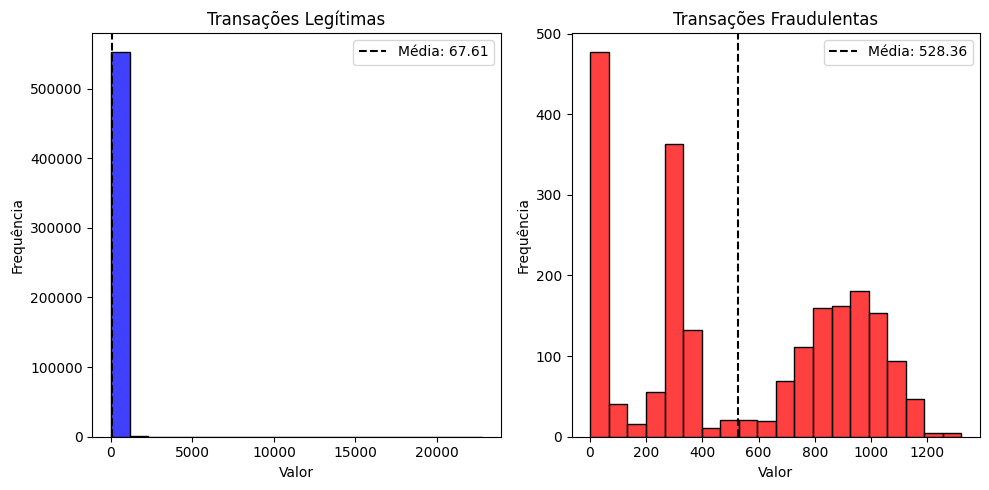

In [17]:
# Class Definition
fraud = Fraud_Detection()
# Load Data
fraud.load_dataset('../data/fraud_test.csv')
# Data Description and Descriptive Statistics for the Amount of Transactions
fraud.data_description()
fraud.descriptive_statistics_amt()

In [18]:
# Pre-processing the Data
fraud.pre_processing()

>> Data types changes: ...
>> Data types changes: DONE
>> Feature Engineeging: ...
     >> Age feature
     >> Time features
     >> Fraud per City Habitant feature
>> Feature Engineeging: DONE
>> Feature Selection: ...
>> Feature Selection: DONE
>> Data Preparation: ...
     >> Encoding: DONE
     >> Data Balancing: DONE
     >> Normalization: DONE
>> Data Preparation: DONE


--------- K-Nearest Neighbour -----------
Fold 1: Potencial overfitting: pontuação de treinamento superior (0.92) à pontuação de teste (0.56), num threshold de 0.2.
Fold 2: Potencial overfitting: pontuação de treinamento superior (0.92) à pontuação de teste (0.69), num threshold de 0.2.
Fold 3: Potencial overfitting: pontuação de treinamento superior (0.92) à pontuação de teste (0.62), num threshold de 0.2.
Fold 4: Potencial overfitting: pontuação de treinamento superior (0.93) à pontuação de teste (0.72), num threshold de 0.2.
Fold 5: No sign of overfitting
Fold 6: Potencial overfitting: pontuação de treinamento superior (0.92) à pontuação de teste (0.63), num threshold de 0.2.
Fold 7: Potencial overfitting: pontuação de treinamento superior (0.93) à pontuação de teste (0.63), num threshold de 0.2.
Fold 8: No sign of overfitting
Fold 9: Potencial overfitting: pontuação de treinamento superior (0.92) à pontuação de teste (0.66), num threshold de 0.2.
Fold 10: Potencial overfitting: pon

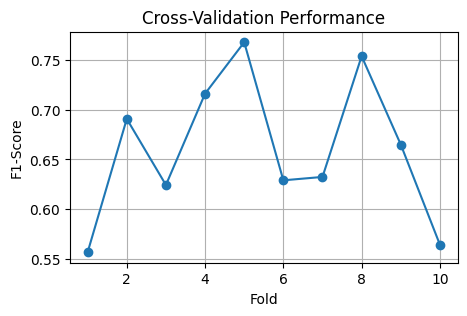

,model,n_neighbors,weights,algorithm,final_f1_score
0,KNeighborsClassifier,5,uniform,auto,0.922


--------- Random Forest Classifier -----------
Fold 1: No sign of overfitting
Fold 2: No sign of overfitting
Fold 3: No sign of overfitting
Fold 4: No sign of overfitting
Fold 5: No sign of overfitting
Fold 6: No sign of overfitting
Fold 7: No sign of overfitting
Fold 8: No sign of overfitting
Fold 9: No sign of overfitting
Fold 10: Potencial overfitting: pontuação de treinamento superior (1.0) à pontuação de teste (0.8), num threshold de 0.2.


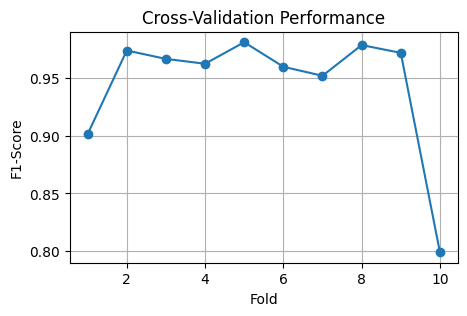

,model,n_estimators,criterion,max_depth,final_f1_score
0,RandomForestClassifier,100,gini,None,1.0


--------- Gradient Boosting Classifier -----------
Fold 1: No sign of overfitting
Fold 2: No sign of overfitting
Fold 3: No sign of overfitting
Fold 4: No sign of overfitting
Fold 5: No sign of overfitting
Fold 6: No sign of overfitting
Fold 7: No sign of overfitting
Fold 8: No sign of overfitting
Fold 9: No sign of overfitting
Fold 10: No sign of overfitting


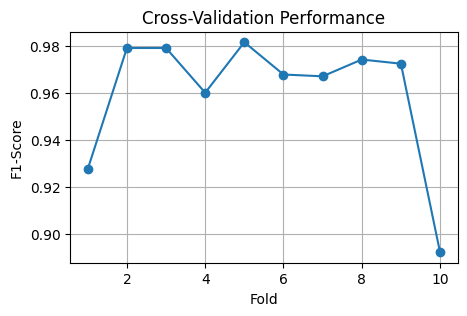

,model,n_estimators,learning_rate,max_depth,final_f1_score
0,GradientBoostingClassifier,100,0.1,3,0.988


In [19]:
# Cross Validation Report
fraud.cross_validation_report(model = 'knn', folds = 10, threshold = 0.2)
fraud.cross_validation_report(model = 'rfc', folds = 10, threshold = 0.2)
fraud.cross_validation_report(model = 'gbc', folds = 10, threshold = 0.2)

# Model Champion

A seleção dos modelos envolveu a comparação cruzada entre os modelos K-Nearest Neighbour, Random Forest Classifier and Gradiente Boost Classifier. O k-NN apresentou muito sinal de possível overfitting em diversos fold da validação cruzada, o que lhe torna rejeitável. 

Já a Random Forest Classifier, apesar de não ter apresentado sinais potenciais de overfitting no relatório de validação cruzada sob um threshold de 0.2, a performance do modelo ao final, com um F1-Score de 1 - uma pontuação perfeita, pode indicar que o modelo está se ajustando excessivamente aos dados de treinamento, seja por conta dos parâmetros padrões (não otimizados) ou pela necessidade de um volume maior de dados, uma vez que a quantidade da base de treino foi reduzida devido ao undersampling.

Portanto, Gradient Boosting Classifier foi eleito o modelo campeão.O Gradient Boosting Classifier é um modelo que constrói um conjunto de modelos de previsão fracos, geralmente árvores de decisão rasas, de forma iterativa. Ele funciona construindo árvores de decisão em uma sequência, onde cada árvore tenta corrigir os erros dos modelos anteriores. Aqui estão algumas das principais características deste modelo com base nos resultados da validação cruzada:

**Test Score**:
   - A pontuação média do modelo no conjunto de teste é de aproximadamente 0.96, variando de 0.892 a 0.981 em diferentes folds da validação cruzada. Isso indica um desempenho bastante consistente e preciso do modelo nos dados de teste.

**Train Score**:
   - A pontuação média do modelo no conjunto de treinamento é de aproximadamente 0.988, variando de 0.987 a 0.989 em diferentes folds da validação cruzada. Isso sugere que o modelo está se ajustando bem aos dados de treinamento, mas não está superajustando (overfitting) significativamente, já que as pontuações de treino são ligeiramente menores do que as pontuações de teste.

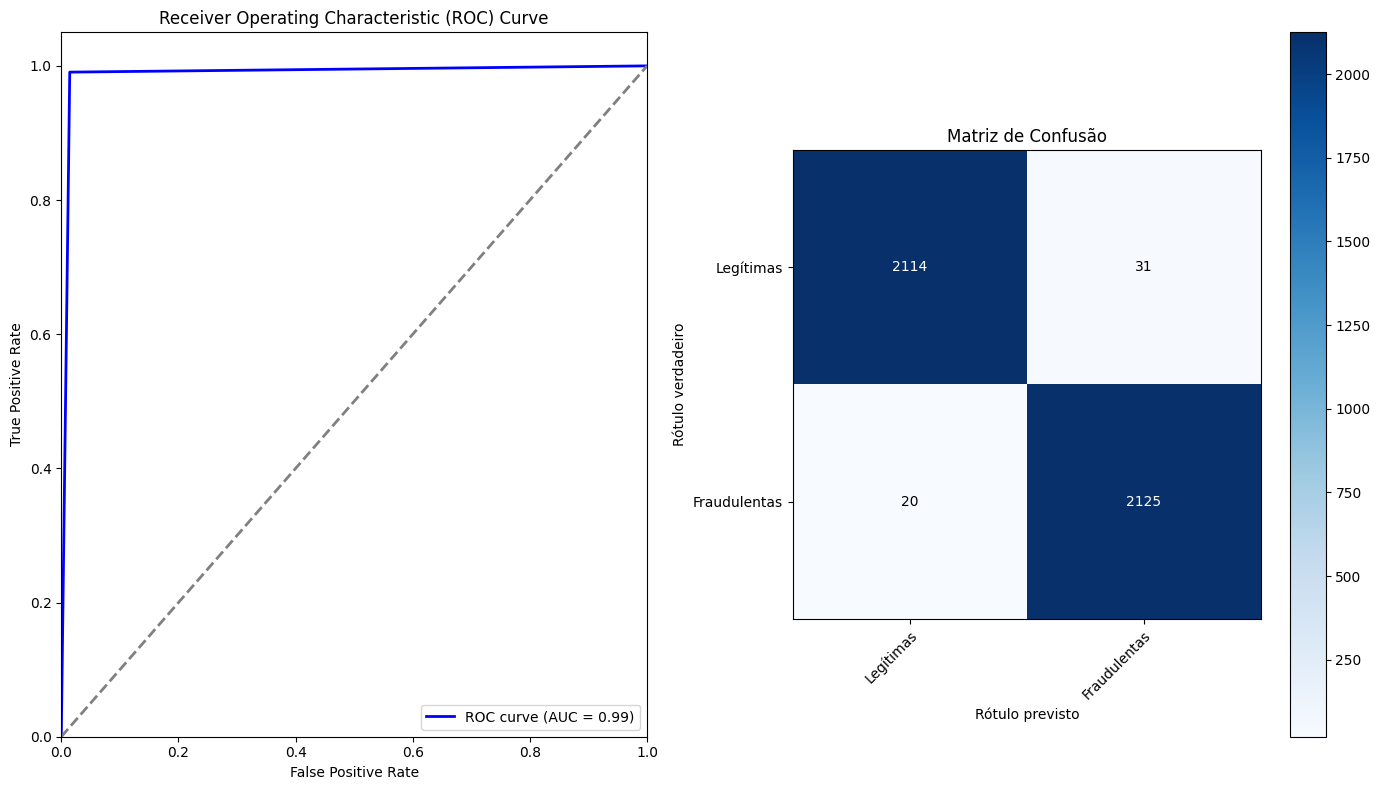

In [20]:
# Plotting ROC Curve and Confusion Matrix
fraud.plot_classification_viz(normalize=False)

In [21]:
fraud.financial_impact_report()


        Relatório de Impacto Financeiro:

        Sem o modelo de detecção de fraude, o custo com a cobertura de transações fraudulentas foi de $1,133,324.68.
        Se o modelo estivesse implementado, economizaríamos cerca de $1,132,325.80, com cerca de $998.88 de custo devido a
        falhas (falsos negativos)
        Assim sendo, o retorno sobre o investimento (ROI) seria de $113,259.54%.


# Conclusão

Ao final do desenvolvimento, podemos apontar que o modelo está apto a servir como instrumento para embasar decisões e ações orientadas a combater e prevenir fraude em transações de cartão de crédito, fornecendo uma identificação precisa das transações que são caracterizadas como fradulentas.

Pode-se elencar aspectos a serem melhorados como:

* Método de balanceamento de dados: testar a aplicação de Oversampling ou uma mistura
* Aprimorar a seleção de variável: eleger um método mais estatisticamente orientado
* Relizar ajuste fino dos hiperparâmetros: aprimor a modelagem por meio da seleção de melhores hiperparâmetros
* Reunir mais dados: aumentar o volume de dados históricos

João Pedro Vazquez

[![Linkedin](https://i.stack.imgur.com/gVE0j.png) LinkedIn](https://www.linkedin.com/in/joao-pedro-vazquez/)
&nbsp;
[![GitHub](https://i.stack.imgur.com/tskMh.png) GitHub](https://github.com/jpvazquezz)